In [10]:
import pandas as pd
import torch
import torch.nn as nn
import string
import numpy as np

# Load the dataset
data = pd.read_csv('dataset/pokemon.csv')["name"]
words = data.to_list()
words = list(map(str.lower, words[:100]))

In [11]:
len(words)

100

In [12]:
char_set = list(string.ascii_lowercase)
char_dict = {char: idx for idx, char in enumerate(char_set)}
char_dict

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25}

In [13]:
class SelfAttention(nn.Module):
    def __init__(self, embedding_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(embedding_dim, embedding_dim)
        self.key = nn.Linear(embedding_dim, embedding_dim)
        self.value = nn.Linear(embedding_dim, embedding_dim)
        self.scale = torch.sqrt(torch.FloatTensor([embedding_dim]))

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attention_weights = torch.matmul(Q, K.permute(0, 2, 1)) / self.scale
        attention_weights = torch.softmax(attention_weights, dim=-1)
        output = torch.matmul(attention_weights, V)
        return output

class AttentionCharacterEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(AttentionCharacterEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.attention = SelfAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, embedding_dim)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        attention_out = self.attention(lstm_out)
        final_embedding = self.fc(attention_out[:, -1, :])  # Final embedding after attention
        return final_embedding

# Initialize Attention model
attention_model = AttentionCharacterEmbeddingModel(vocab_size, embedding_dim, hidden_dim)


class HybridCharacterEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(HybridCharacterEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.attention = SelfAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, embedding_dim)

    def forward(self, x):
        embeds = self.embedding(x).permute(0, 2, 1)
        conv_out = torch.relu(self.conv1(embeds)).permute(0, 2, 1)
        lstm_out, _ = self.lstm(conv_out)
        attention_out = self.attention(lstm_out)
        final_embedding = self.fc(attention_out[:, -1, :])
        return final_embedding

vocab_size = len(char_set)  # Character set size (number of unique characters)
embedding_dim = 50  # Embedding dimension for each character
hidden_dim = 100  # Hidden dimension of Transformer

# Initialize Attention model
model = HybridCharacterEmbeddingModel(vocab_size, embedding_dim, hidden_dim)


In [14]:
def word_to_indices(word, char_to_idx, max_length):
    indices = [char_to_idx[char] for char in word if char in char_to_idx]
    # Pad or truncate to `max_length`
    if len(indices) < max_length:
        indices += [0] * (max_length - len(indices))  # Pad with index 0 for shorter words
    else:
        indices = indices[:max_length]  # Truncate if too long
    return torch.tensor(indices).unsqueeze(0)  # Add batch dimension

In [15]:
max_length = max(len(word) for word in words)
encoded_pokemon = []
for name in words:
    indices = word_to_indices(name, char_dict, max_length)
    embedding = model(indices).detach().numpy()  # Get the sequence-level embedding
    encoded_pokemon.append(embedding)
encoded_pokemon = np.array(encoded_pokemon)

In [16]:
len(encoded_pokemon)

100

(100, 50)


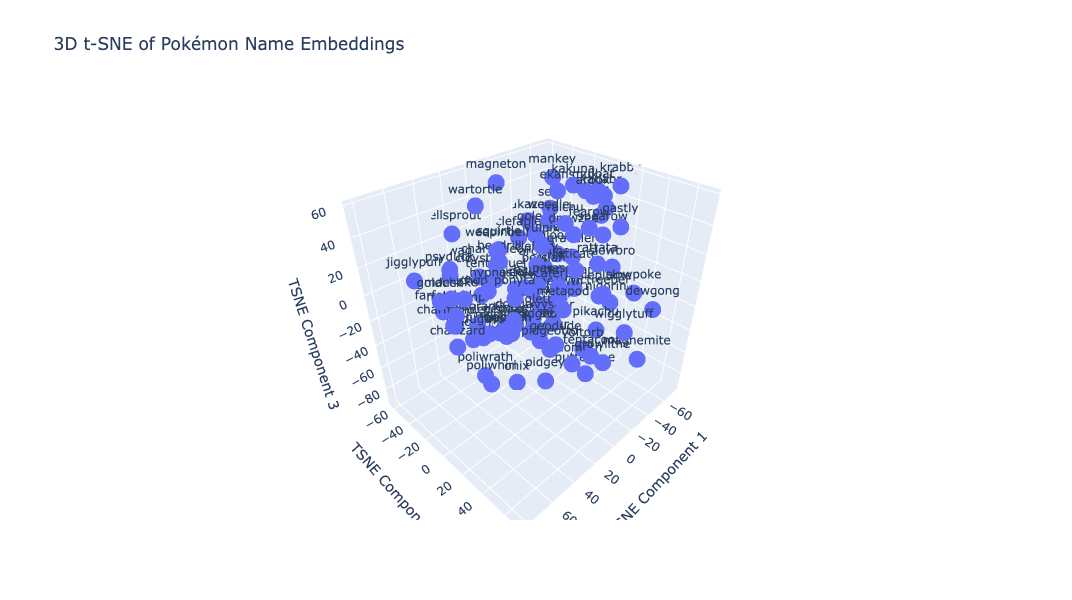

In [17]:
from sklearn.manifold import TSNE

# Dimensionality reduction using t-SNE for 3D visualization
import plotly.express as px

# Flatten the one-hot encoded arrays into a 2D array
flattened_encoded_pokemon = encoded_pokemon.reshape(len(words), -1)  # Reshape to (number of Pokémon, max_length * number of characters)

# Check the shape of the flattened result
print(flattened_encoded_pokemon.shape)  # Should be (number of words, max_length * number of characters)

# Dimensionality reduction using t-SNE for 3D visualization
tsne = TSNE(n_components=3, perplexity=3, random_state=42)
pokemon_tsne_3d = tsne.fit_transform(flattened_encoded_pokemon)

# Create a DataFrame for Plotly visualization
df = pd.DataFrame(pokemon_tsne_3d, columns=['Component 1', 'Component 2', 'Component 3'])
df['Pokémon'] = words  # Add Pokémon names for labeling

# 3D Scatter Plot using Plotly Express
fig = px.scatter_3d(
    df, 
    x='Component 1', 
    y='Component 2', 
    z='Component 3', 
    text='Pokémon',  # Display Pokémon names
    title='3D t-SNE of Pokémon Name Embeddings',
    height=600
)

fig.update_traces(marker_size=10)
fig.update_layout(scene=dict(
    xaxis_title='TSNE Component 1',
    yaxis_title='TSNE Component 2',
    zaxis_title='TSNE Component 3',
))

fig.show()